## Tier3 결과 시각화
`tier3_results.jsonl`을 읽어 승자 분포와 평균 순위를 그립니다.

In [34]:
from pathlib import Path
import json
from collections import Counter
import matplotlib.pyplot as plt

# 설정: 결과 JSONL 경로와 출력 이미지 경로
MODEL_NAMES = ["pretrained", "baseline", "mtl", "frontier"]
RESULT_PATH = Path("tierngf_results.jsonl")  # 필요시 변경
PLOT_PATH = Path("tierngf_results.png")      # 저장 파일 이름

In [35]:
# 결과 로드
records = []
with RESULT_PATH.open("r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        try:
            records.append(json.loads(line))
        except Exception as e:
            print(f"[warn] parse error: {e}")

print(f"Loaded {len(records)} records from {RESULT_PATH}")


Loaded 40 records from tierngf_results.jsonl


In [36]:
# 집계
win_counter = Counter()
rank_counter = {m: Counter() for m in MODEL_NAMES}
errors = []
invalid_rank = []

for r in records:
    winner = r.get("winner", "error")
    ranking = r.get("ranking", [])

    if winner == "error":
        errors.append(r.get("sample_id"))
        continue
    win_counter[winner] += 1

    if len(ranking) != len(MODEL_NAMES) or set(ranking) != set(MODEL_NAMES):
        invalid_rank.append(r.get("sample_id"))
        continue

    for idx, name in enumerate(ranking):
        rank_counter[name][idx + 1] += 1


In [37]:
# 통계 출력
print("승자 분포:")
for m in MODEL_NAMES:
    print(f"  {m:10s}: {win_counter.get(m, 0)}")

print(f"오류 샘플 수      : {len(errors)}")
print(f"순위 이상 샘플 수 : {len(invalid_rank)}")


승자 분포:
  pretrained: 11
  baseline  : 10
  mtl       : 12
  frontier  : 7
오류 샘플 수      : 0
순위 이상 샘플 수 : 0


/tmp/ipykernel_3100490/197527134.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(MODEL_NAMES, rotation=20)
/tmp/ipykernel_3100490/197527134.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(MODEL_NAMES, rotation=20)


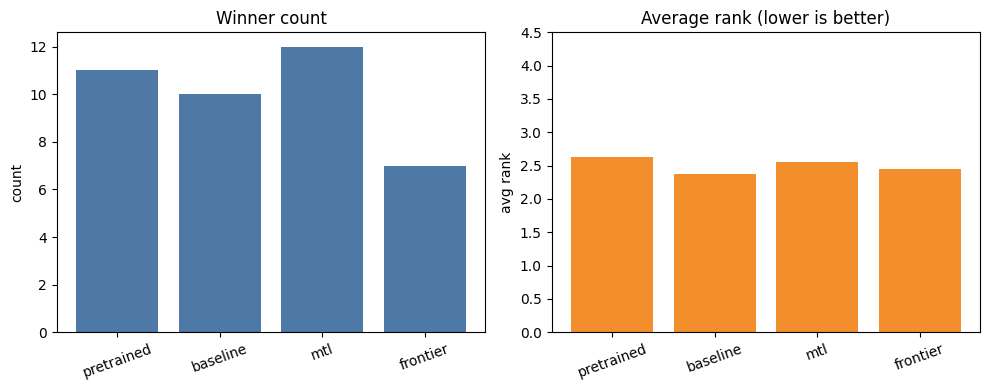

Saved plot to tierngf_results.png


In [38]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# winner 카운트
winners = [win_counter.get(m, 0) for m in MODEL_NAMES]
axes[0].bar(MODEL_NAMES, winners, color="#4e79a7")
axes[0].set_title("Winner count")
axes[0].set_ylabel("count")
axes[0].set_xticklabels(MODEL_NAMES, rotation=20)

# 평균 순위 (낮을수록 우수)
avg_ranks = []
for m in MODEL_NAMES:
    total = sum(rank_counter[m].values())
    if total == 0:
        avg = float('nan')
    else:
        avg = sum(rank * cnt for rank, cnt in rank_counter[m].items()) / total
    avg_ranks.append(avg)

axes[1].bar(MODEL_NAMES, avg_ranks, color="#f28e2b")
axes[1].set_title("Average rank (lower is better)")
axes[1].set_ylabel("avg rank")
axes[1].set_xticklabels(MODEL_NAMES, rotation=20)
axes[1].set_ylim(0, len(MODEL_NAMES) + 0.5)

fig.tight_layout()
plt.show()

fig.savefig(PLOT_PATH, dpi=200)
print(f"Saved plot to {PLOT_PATH}")
